<img src="images/logo.png" style="width: 100px;"/>
<h1><center>Assignment 2</center></h1>
<h3><center>Decision Trees</center></h3>

<center>Due: 09.11.2021 at 23:59</center>

### How to upload:

Upload your solution via the VC course. Please upload **one Zip archive** per group. The Zip must contain:
* Your solution **notebook** (a **.ipynb** file)
* An **images folder** with all your images (keep the size of the images relatively small)
* A **data folder** with the datasets (you probably don't have to change anything here)

Your Zip should be named after the following scheme:

* assignment\_"**assignment number**"\_solution.zip

# 1) Entropy

Calculating the entropy is a thing that has to be done repeatedly when training a decision tree. Let's write a function for that. Our input is again the mushroom dataset, which we will first load into Pandas:

In [1]:
import pandas as pd
import numpy as np

# Load the data
data = pd.read_csv("data/UCI_mushroom_data.csv", sep=",")
data.head()

,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,0,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,0,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,1,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,0,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Now that we have the dataset loaded, let's write a function that will calculate us a multiclass entropy for a (subset of a) pandas dataframe. The input will be the dataframe and the column name of the target attribute. The function should figure out itself how many classes there are. For this you can have a look at the __df.unique()__ function of Pandas.

In [2]:
def multiclass_entropy(data, target_attribute):
    
    #for figuring out how many classes there are
    levels = data[target_attribute].unique()
    
    # Initialize the entropy to 0
    entropy = 0
    
    # for each value in the target attribute values
    for level in levels:
        # ratio of values occurring and entropy
        fraction = data[target_attribute].value_counts()[level] / len(levels)
        entropy += -fraction * np.log2(fraction)
    return entropy
 
multiclass_entropy(data, "poisonous")


-29639.63795925816

# 2) Information Gain 

Create a function that given a dataset, an attribute name and a target column name, calculates the information gain for the given attribute:

The Method should work with the following call:

Method-Call: information_gain(data=data, attribute="odor", target_attribute="poisonous")

In [3]:
def information_gain(data, attribute, target_attribute):  
    
    # Calculate the original entropy
    original_entropy = multiclass_entropy(data, target_attribute)
    # print(original_entropy)

    #Type of values of attribute
    values = data[attribute].unique()
    #print(multiclass_entropy(data, attribute))
    
    #Calculate the values and the corresponding counts for the split attribute 
    vals,counts= np.unique(data[attribute],return_counts=True)
    #print(vals,counts)
    
    for i in range(len(vals)):
        #Calculate the weighted entropy
        Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*multiclass_entropy(data,attribute) ])
    
        #Calculate the information gain
        Information_Gain = original_entropy - Weighted_Entropy
    return Information_Gain    



information_gain(data, "bruises", "poisonous")



-12964.385264594355

What column has the **highest information gain**?

In [4]:
#print(np.array(data.keys())[1:])
def highest_info_gain(columns):

    # Intialize an empty dictionary for information gains

    information_gains = {}
    

    # Iterate through each column name in our list

    for col in columns:

        # Find the information gain for the column

        IG = information_gain(data, col, 'poisonous')
        # Add the information gain to our dictionary using the column name as the ekey

        information_gains[col] = IG

    # Return the key with the highest value
    return max(information_gains) , information_gains[max(information_gains)]


highest_info_gain(np.array(data.keys())[1:])                                       

('veil-type', 40698.72486728079)

# 3) Evaluate a decision tree

In this task you will use different decision trees to classify data.
Therefore we first need two classes that represent a single node and a single edge of a decision tree:

In [5]:
class Node:
    """
    value: The name of the decision attribute. If this is a leaf node, 'value' is the prediction value
    edges: A list of edge objects
    """
    def __init__(self):
        self.value = ""
        self.edges = []

class Edge:
    """
    label: An attribute value.
    node: The subsequent node that is hanging at this edge.
    """
    def __init__(self):
        self.label = ""
        self.node = None

The __Node__ class has a property for the __value__ (either an attribute or a class for the leaf nodes) and a property for the list of outgoing __edges__. This list should be filled with objects of the class __Edge__.

The __Edge__ class has a property for the __label__ of the edge as well as a property for the attached __node__ that comes at the next layer.

Since we also want to show our decision tree, we also give you functions to print your tree:

In [6]:
def print_tree(root):
    print(print_tree_at_layer(root, 0))

def print_tree_at_layer(tree, layer):
    text = str(tree.value)
    text += "\n"
    if not len(tree.edges) == 0:
        for e in tree.edges:
            text += "\t" * (layer+1)
            text += f"{e.label}: {print_tree_at_layer(e.node, layer + 1)}"
    return text

The function __print_tree(root)__ takes the root node (an object of class __Node__) of the tree and prints it in a typical 'console directory printing style' where each line contains one node (with a possible edge label prefix). The indentation gives an indication at which layer we currently are. __print_tree_at_layer__ is an auxiliary function.

Your task is now to write a function `inference` that takes an instance and classifies it with a given decision tree. We give you a simple example of a decision tree so that you can test you function.

In [7]:
# example tree
tree = Node()
tree.value = "A"
tree_B = Node()
tree_B.value = "B"
tree_C = Node()
tree_C.value = "C"
tree_D = Node()
tree_D.value = "D"
tree_E = Node()
tree_E.value = "E"

edge_to_B = Edge()
edge_to_B.label = "b"
edge_to_B.node = tree_B

edge_to_C = Edge()
edge_to_C.label = "c"
edge_to_C.node = tree_C

edge_to_D = Edge()
edge_to_D.label = "d"
edge_to_D.node = tree_D

edge_to_E = Edge()
edge_to_E.label = "e"
edge_to_E.node = tree_E

tree.edges = [edge_to_B, edge_to_C]
tree_B.edges = [edge_to_D, edge_to_E]

# print(tree)
print_tree(tree)

def inference(example, tree, attributes):
    """
    example: Single instance to be classified, in the form of an array containing the attribute values
    tree: The root node of a decision tree, built with the classes Node and Edge from above
    attributes: An index array that contains the attribute names in the order in which the attributes appear in example
    """
    currentNode = tree
    while(currentNode):
        if len(currentNode.edges) == 0:
          return currentNode.value;
        edge_label = example[attributes.index(currentNode.value)]
        # print(edge_label)
        for edge in currentNode.edges:
          if edge.label == edge_label:
            currentNode=edge.node
            break;

A
	b: B
		d: D
		e: E
	c: C



In [8]:
# Use this as a test - write more tests if you want
'E' == inference(["b", "e"], tree, ["A", "B"])
# 'B' == inference(["b"], tree, ["A"])
# print(inference(["b", "e"], tree, ["A", "B"]))


E


In the next task, we want you to **use the inference-function to evaluate how well pre-trained decision trees perform on test data**.    
Here is some background information on how we obtained the decision trees: We chose a data set from the UCI-libraries (https://archive.ics.uci.edu/ml/datasets/Breast+Cancer) denoting whether a person had a recurring case of breast cancer, along with other medical information. We split the data into a training and a test set. We applied two different (unknown to you ;) ) adaptations of the ID3-algorithm to train two decision trees on the train set. Here are the datasets we used and the trees (`tree1`, `tree2`) we generated.

In [9]:
import pickle

with open('data/tree1.pickle', 'rb') as file:
    tree1 = pickle.load(file) 
    
with open('data/tree2.pickle', 'rb') as file:
    tree2 = pickle.load(file)
    
training_df = pd.read_csv('data/train.csv', dtype=object)
test_df = pd.read_csv('data/test.csv', dtype=object)


attributes = np.array(test_df.keys())[1:].tolist()

tree1_test_prediction = []
tree2_test_prediction = []
for row in np.array(test_df):
  x=inference(row[1:].tolist(), tree1, attributes)
  tree1_test_prediction.append(x)
  x=inference(row[1:].tolist(), tree2, attributes)
  tree2_test_prediction.append(x)  
tree1_test_prediction = np.array(tree1_test_prediction)
tree2_test_prediction = np.array(tree2_test_prediction)
test_classes=np.array(test_df)[:,0:1].reshape((1,test_df.shape[0]))[0];
# tree1_error=train_result.shape[0]-(tree1_inference==train_result).sum()
# tree2_error=train_result.shape[0]-(tree2_test_inference==train_result).sum()


tree1_train_prediction = []
tree2_train_prediction = []
for row in np.array(training_df):
  x=inference(row[1:].tolist(), tree1, attributes)
  tree1_train_prediction.append(x)
  x=inference(row[1:].tolist(), tree2, attributes)
  tree2_train_prediction.append(x)
tree1_train_prediction = np.array(tree1_train_prediction)
tree2_train_prediction = np.array(tree2_train_prediction)
train_classes=np.array(training_df)[:,0:1].reshape((1,training_df.shape[0]))[0];
# tree1_error=train_result.shape[0]-(tree1_inference==train_result).sum()
# tree2_error=train_result.shape[0]-(tree2_inference==train_result).sum()


In [10]:
# print_tree(tree2)

inv-nodes
	0-2: tumor-size
		30-34: 0
		20-24: 0
		15-19: 0
		0-4: 0
		25-29: 0
		50-54: 0
		10-14: 0
		40-44: 0
		35-39: 0
		5-9: 0
		45-49: 1
	6-8: deg-malig
		3: 1
		2: 0
		1: 1
	9-11: age
		30-39: 1
		40-49: 0
		60-69: 1
		50-59: 0
		70-79: 1
		20-29: 1
	3-5: deg-malig
		3: 1
		2: 0
		1: 0
	15-17: menopause
		premeno: 1
		ge40: 0
		lt40: 0
	12-14: tumor-size
		30-34: 1
		20-24: 0
		15-19: 0
		0-4: 0
		25-29: 0
		50-54: 0
		10-14: 0
		40-44: 0
		35-39: 0
		5-9: 0
		45-49: 0
	24-26: 1



Now use your inference function from above to check if the trees predict correctly. **To do this calculate the accuracy of the predictions of the target attribute on both the training-set and the test-set for both trees.**

*In the dataset the attribute `Class` denotes the target attribute.*

In [11]:
from sklearn.metrics import accuracy_score
tree1_accuracy = accuracy_score(test_classes, tree1_test_prediction)
tree2_accuracy = accuracy_score(test_classes, tree2_test_prediction)
print(tree1_accuracy)
print(tree2_accuracy)

0.6744186046511628
0.7674418604651163


**Questions:**
(1) Looking at these accuracies, would you rather use tree1 or tree2 in a real world scenario to predict whether a person might have recurring breast cancer? Explain your choice and explicitly explain why you did **not** choose a certain tree. Try to come up with an explanation for the accuracy values of the two trees.   
(2) What do you think were the adaptations we used when training the two trees?

*Hint: You can also print both trees with the function print_tree(root) and compare the output for additional information*

*Your solution here*

Answer:(1)

From the result it seems `tree2` gives higher accuracy `tree1`. But from the visualisation of `tree2` shows that, decision depends only on inv-nodes and one other attribute. That's why it's showing high accuracy.

So in real world scenario, `tree1` will show better usability.


---
# Tips and tricks


### 1) Embedding images
You can embed images in a jupyter notebook on two ways: <br/>
First, you can use the IPython kernel to draw an image everytime the code cell is run like shown below.

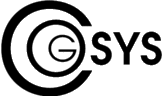

In [12]:
from IPython.display import Image
Image("images/logo.png")

Second, you can embed images directly in a Markdown cell as shown below. You can either use markdown syntax or write plain HTML code. Sometimes HTML code is more practical, as you have much finer control over the HTML elements.

1. Markdown syntax:
![title](images/logo.png)
2. HTML syntax
<img src="images/logo.png" style="width: 70px;"/>